In [1]:
import os
import argparse
import numpy as np
from scipy.io import wavfile
import features as mfcc
from hmmlearn import hmm
import sklearn.mixture as skm
import pickle

In [2]:
def getUbmFeatures(files):
    """
    
    
    """

    digit_features = {}
    
    for d in files:
        
        all_speaker_features  = []

        for filename in files[d]:

            sampling_rate, audio_signal = wavfile.read(filename)

            feat = mfcc.getMFCC(audio_signal,sampling_rate)

            all_speaker_features.append(feat)

        digit_features[d] = all_speaker_features
        
    return digit_features

In [18]:
def getSpeakerFeatures(speaker_file,features = 13):
    
    NUM_FEAT = features
    
    speaker_features = {}
      
    length = len(speaker_file) #number of digits(words)

    for d in range(length):
        
        utterances = len(speaker_file[d])

        digit_features = []
        
        for i in range(utterances):
            
            sampling_rate, audio_signal = wavfile.read(speaker_file[d][i])
            feat = mfcc.getMFCC(audio_signal,sampling_rate,trimSilence=False,NUM_FEAT = 13)          
            digit_features.append(feat)
            
        speaker_features[d] = np.array(digit_features)
        
    return speaker_features

In [4]:
ubm_files = pickle.load(open("ubm_data.f","rb"))
ubm_features = getUbmFeatures(ubm_files)

In [5]:
hmm_UBM = {}
gmm_UBM = {}
hmm_posteriors = {}
gmm_posteriors = {}

for digit in ubm_features:
    digit_hmm = hmm.GMMHMM(n_components=8, n_mix = 8, n_iter=100, covariance_type='diag',init_params="", params="cmt")
    digit_gmm = skm.GaussianMixture(n_components=64,covariance_type='diag')
        
    lengths = []
    
    X = []
    for u in ubm_features[digit]:
        lengths.append(len(u))
        if len(X) == 0:
            X = u
        else:
            X = np.concatenate([X, u])
            
    digit_gmm.fit(X)

    digit_hmm.fit(X,lengths)    
    
    hmm_UBM[digit] = digit_hmm 
    gmm_UBM[digit] = digit_gmm  
    

In [36]:
def map_adaptation(gmm, data, max_iterations = 10, likelihood_threshold = 1e-20, relevance_factor = 16):
    N = data.shape[0]
    D = data.shape[1]
    K = gmm.n_components
    
    mu_new = np.zeros((K,D))
    n_k = np.zeros((K,1))
    
    mu_k = gmm.means_
    cov_k = gmm.covariances_
    pi_k = gmm.weights_

    old_likelihood = gmm.score(data)
    new_likelihood = 0
    iterations = 0
    while(abs(old_likelihood - new_likelihood) > likelihood_threshold and iterations < max_iterations):
        iterations += 1
        old_likelihood = new_likelihood
        z_n_k = gmm.predict_proba(data)
        n_k = np.sum(z_n_k,axis = 0)

        for i in range(K):
            temp = np.zeros((1,D))
            for n in range(N):
                temp += z_n_k[n][i]*data[n,:]
            mu_new[i] = (1/n_k[i])*temp

        adaptation_coefficient = n_k/(n_k + relevance_factor)
        for k in range(K):
            mu_k[k] = (adaptation_coefficient[k] * mu_new[k]) + ((1 - adaptation_coefficient[k]) * mu_k[k])
        gmm.means_ = mu_k

        log_likelihood = gmm.score(data)
        new_likelihood = log_likelihood
        
    return gmm

In [11]:
speaker_files = pickle.load(open("enrollment_data.f","rb"))
# speaker_features = getSpeakerFeatures(speaker_files)

In [24]:
speakers_features= {}

for s in speaker_files:
    speakers_features[s] = getSpeakerFeatures(speaker_files[s])
    

In [31]:
gmm_UBM[str(0)]

GaussianMixture(covariance_type='diag', n_components=64)

In [37]:
all_speakers_model = {}
for s in speakers:
    speaker_model ={}
    for i in range(10):
        for u in speakers[s][i]:
            s_gmm = map_adaptation(s_gmm, u, max_iterations = 10, likelihood_threshold = 1e-20, relevance_factor = 16)
        speaker_model[i] = s_gmm
    all_speakers_model[s] =speaker_model

In [40]:
speaker_model

{0: GaussianMixture(covariance_type='diag', n_components=64),
 1: GaussianMixture(covariance_type='diag', n_components=64),
 2: GaussianMixture(covariance_type='diag', n_components=64),
 3: GaussianMixture(covariance_type='diag', n_components=64),
 4: GaussianMixture(covariance_type='diag', n_components=64),
 5: GaussianMixture(covariance_type='diag', n_components=64),
 6: GaussianMixture(covariance_type='diag', n_components=64),
 7: GaussianMixture(covariance_type='diag', n_components=64),
 8: GaussianMixture(covariance_type='diag', n_components=64),
 9: GaussianMixture(covariance_type='diag', n_components=64)}

In [ ]:
def getStats(posterior,features,ubm_mean,feat_vec=13):    
    
    n_frames,n_components = posterior.shape
    I = np.eye(feat_vec)
    N_c = np.sum(posterior,axis = 0)
    N = []
    F = []
    for c in range(n_components):
        Fc = []
        for f in range (n_frames):
            Fc.append(posterior[f][c] * (features[f]-ubm_mean[c]))
            
        N.append(N_c[c]*I)
        F.append(np.sum(np.array(Fc),axis=0))
            
    F = np.array(F)   
    N = np.array(N)
    
    return N,F
    
    

In [ ]:
def logLiklihoodRatio(logLSpeaker, logLUbm):
    return logLSpeaker - logLUbm

In [ ]:
Nd_s ={}
Fd_s ={}
for digit in ubm_features:
    N_s = []
    F_s = []
    for u in ubm_features[digit]:
        posteriors = gmm_UBM[digit].predict_proba(u)
        N,F = getStats(posteriors,u,gmm_UBM[digit].means_)
        N_s.append(N)
        F_s.append(F)
    Nd_s[digit] = np.array(N_s)
    Fd_s[digit] = np.array(F_s)


In [ ]:
def trainTotalVariability(N,F,ubm,num_speakers,num_Components,n_iter=3):
    
    I = np.eye(num_speakers)
    sinv = np.linalg.pinv(ubm.covariances_)
    T =  np.random.rand(sigma.shape[0],sigma.shape[1],num_speakers)
    print("T",T.shape)
    print("sinv",T.shape)
    
    for i in range(n_iter):
        
        TinvS = np.dot((T.T),sigma)
        print("TinvS",TinvS.shape)
        
        Ey = np.zeros((num_speakers,1))
        Eyy = np.zeros((num_speakers,1))
        Linv = np.zeros((num_speakers,1))
        
        for s in range(num_speakers):
            print("N[s]",N[s].shape)
            
            L = (I + np.dot(np.dot(TinvS,N[s]),T))
            Linv[s] = np.linalg.pinv(L)
            Ey[s] = np.dot(np.dot(Linv[s],TinvS[s]),(F[s]))
            Eyy[s] = Linv[s] + Ey[s]*Ey[s].T
             
        C = np.sum(F*Ey.T)
        print(C.shape)

        newT = np.zeros((num_Components,1))
        for c in range(num_Components):
            Ac = np.zeros(num_speakers)
            for s in range(num_speakers):
                Ac = Ac + N[s][c]*Eyy[s]

            newT[c] = (np.linalg.pinv(Ac)*C[c]).T

        T = newT
    return T

In [ ]:
# variability_matrices = {}

# for digit in gmm_UBM:
num_speakers = Nd_s['0'].shape[0]
num_Components = Nd_s['0'].shape[1]
variability_matrices['0'] = trainTotalVariability(Nd_s['0'],Fd_s['0'],gmm_UBM['0'],num_speakers,num_Components,n_iter=3)

In [ ]:
sigma = gmm_UBM['0'].precisions_

num_speakers = Nd_s['0'].shape[0]
num_components = Nd_s['0'].shape[1]

T =  np.random.rand(sigma.shape[0],sigma.shape[1])
I = np.eye(num_speakers)
TinvS = ((T)/sigma).T


L =np.dot(TinvS*Nd_s['0'][0],T)
Linv = np.linalg.pinv(L)
Ey =np.dot(np.dot(Linv,TinvS),(Fd_s['0'][0]))
Eyy= Linv[s] + Ey*Ey.T

In [ ]:
def getI_vector(N,F,T,SigmaInv,t_dim):
    
    I = np.eye(t_dim);
    TSinv = (T.T)*SigmaInv
    cov_i = I + ((TSinv*N).dot(T))
    V = np.dot(TSinv,F)
    ivector = np.dot(np.linalg.pinv(cov_i) ,V)
    
    return ivector

In [ ]:
gmm_UBM['0'].precisions_.shape
array = np.zeros((64,64,13))

for i in range(64):
    array[i]= gmm_UBM['0'].precisions_

array.shape

In [ ]:
speaker_models = {}
for s in enroll_features:
    sp_digit_model = {}
    for d in enroll_features[s]:
        
        x = enroll_features[s][d]
        model = all_digit_UBM[d].predict_proba(x[0])
        sp_digit_model[d] = model
        
        #would save ubm for speaker here:
    speaker_models[s] = sp_digit_model


        
        
        

In [ ]:
fakeutterance = ['0','5','6','7','9','3','2']


for dig in fakeutterance:
    scores ={}
    for digit in all_digit_UBM:

        model = all_digit_UBM[digit]
        score = model.score(test_features['george'][dig][0])
        scores[digit] = score
    predict = max(scores, key=scores.get)
    print("Test on true label ", dig,": predict result label is ", predict)
    
    


In [ ]:
def score(sim,lenOfutterance = 6):
    score = np.sum(sim)/lenOfutterance
    

In [ ]:
def cosineSimilarity(en_iVector, tes_iVector):
    sim = np.dot(en_iVector, tes_iVector)/(np.linalg.norm(en_iVector)*np.linalg.norm(tes_iVector))
    return sim

In [ ]:
def S_w(iVectors,n_u,n_s):
    
    for s in range(n_s):
        w_mus = np.mean(iVectors[s],axis = 1)
        for i in range(n_u):
            (iVectors[s][i] - w_mus)*(iVectors[s][i] - w_mus).T

def S_b(iVectors,n_u,n_s):
    w_mu = np.mean(iVectors,axis = 1)
    for s in range(n_s):
        w_mus = np.sum(iVectors[s],axis = 1)
        (iVectors[s] - w_mu)*(iVectors[s] - w_mu).T

In [ ]:
def LDA(W,S_b,S_w,S_u):
    #i vectir per speaker
    # u utterance per speaker
    # projection matrix as I
    #get s_w and s_b
    #solve eigen equation and multiply by i_vector
    #multiply by projection matrix
    return J

In [42]:
speaker_files

{'Speaker1': [['../data\\Speaker1\\digits\\0_Speaker1_0.wav',
   '../data\\Speaker1\\digits\\0_Speaker1_1.wav',
   '../data\\Speaker1\\digits\\0_Speaker1_2.wav',
   '../data\\Speaker1\\digits\\0_Speaker1_3.wav',
   '../data\\Speaker1\\digits\\0_Speaker1_4.wav'],
  ['../data\\Speaker1\\digits\\1_Speaker1_0.wav',
   '../data\\Speaker1\\digits\\1_Speaker1_1.wav',
   '../data\\Speaker1\\digits\\1_Speaker1_2.wav',
   '../data\\Speaker1\\digits\\1_Speaker1_3.wav',
   '../data\\Speaker1\\digits\\1_Speaker1_4.wav'],
  ['../data\\Speaker1\\digits\\2_Speaker1_0.wav',
   '../data\\Speaker1\\digits\\2_Speaker1_1.wav',
   '../data\\Speaker1\\digits\\2_Speaker1_2.wav',
   '../data\\Speaker1\\digits\\2_Speaker1_3.wav',
   '../data\\Speaker1\\digits\\2_Speaker1_4.wav'],
  ['../data\\Speaker1\\digits\\3_Speaker1_0.wav',
   '../data\\Speaker1\\digits\\3_Speaker1_1.wav',
   '../data\\Speaker1\\digits\\3_Speaker1_2.wav',
   '../data\\Speaker1\\digits\\3_Speaker1_3.wav',
   '../data\\Speaker1\\digits\\3_Sp

In [44]:
import trimmer


In [47]:
len(signals)

1

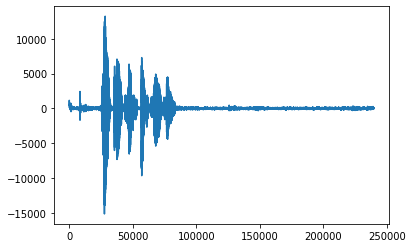

In [48]:
import matplotlib.pyplot as plt

plt.plot(audio_signal)

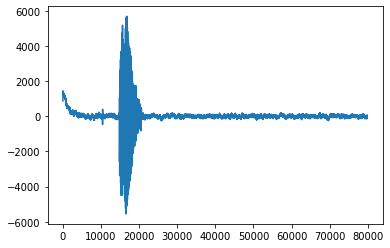

In [59]:
sampling_rate, audio_signal = wavfile.read('../data\\Speaker1\\digits\\2_Speaker1_0.wav')
trimmed = trimmer.trim_silence(audio_signal,np.max(audio_signal[len(audio_signal)-50000:-1]))
plt.plot(audio_signal)

In [56]:
np.max(audio_signal[len(audio_signal)-50000:-1])

326